In [1]:
#!pip install pyreadstat
#!pip install matplotlib seaborn
#!pip install mplcursors

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib
import mplcursors
import warnings
warnings.filterwarnings('ignore')

In [3]:
plt.rcParams['font.family']='Malgun Gothic'

In [4]:
#데이터 불러오기
raw_welfare = pd.read_spss('D:\syb_data\data\Koweps_hpda18_2023_beta1.sav')
#데이터 불러오기
raw_welfare_19 = pd.read_spss('D:\syb_data\data/Koweps_hpwc14_2019_beta2.sav')
#복사본 만들기
welfare = raw_welfare.copy()
#복사본 만들기
welfare_19 = raw_welfare_19.copy()

In [5]:
#데이터 검토
#welfare           # 앞부분, 뒷부분 확인
#welfare.shape     # 행, 열의 개수
#welfare.info()    # 열의 속성
#welfare.describe() # 요약통계

In [29]:
# 분석에 필요한 열을 결정 // 열 이름 변경
welfare = welfare.rename(
    columns= {'h18_g3' : 'sex',                # 성별
              'h18_g4' : 'birth',              # 태어난 년도
              'h18_g10' : 'marriage_type',    # 혼인 상태
              'h18_g11' : 'religion',          # 종교
              'p1802_8aq1' : 'income',         # 월급
              'h18_eco9' : 'code_job',         # 직업 코드
              'h18_reg7' : 'code_region',      # 지역 코드
              'h18_eco4' : 'eW' ,              # 주된 경제활동 참여상태
              'h18_eco11': 'no_eW',              #비경제활동사유
              'h18_g8' : 'disabled_type', #장애종류
              'h18_med3' : 'hospital_year', #1년간 의료기간 이용 외래진료횟수
              'h18_soc_5' : 'pension_status', #국민연급 납부여부                    
              })    


In [7]:
welfare_19 = welfare_19.rename(
    columns= {'h14_g3' : 'sex',                # 성별
              'h14_g4' : 'birth',              # 태어난 년도
              'h14_g10' : 'marriage_type',    # 혼인 상태
              'h14_g11' : 'religion',          # 종교
              'p1402_8aq1' : 'income',         # 월급
              'h14_eco9' : 'code_job',         # 직업 코드
              'h14_reg7' : 'code_region',       # 지역 코드
              'h14_eco4' : 'eW' ,              # 주된 경제활동 참여상태
              'h14_eco11' : 'no_eW',       # 비경제활동사유
              'h14_g8' : 'disabled_type', #장애종류
              'h14_med3' : 'hospital_year', #1년간 의료기간 이용 외래진료횟수
              'h14_soc_5' : 'pension_status', #국민연급 납부여부  
              })  

In [9]:
welfare = welfare.assign(age = 2019 - welfare['birth']+1 )
welfare['age'].describe()

count    15931.000000
mean        50.575984
std         24.226765
min         -2.000000
25%         32.000000
50%         55.000000
75%         71.000000
max        114.000000
Name: age, dtype: float64

In [27]:
welfare_19 = welfare_19.assign(age = 2019 - welfare['birth']+1 )
welfare_19['age'].describe()

count    13016.000000
mean        54.513599
std         20.665366
min         13.000000
25%         39.000000
50%         57.000000
75%         72.000000
max        114.000000
Name: age, dtype: float64

In [10]:
#연령대에 따른 입금 차이
#초년층 : 30세 미만, 중년층 : 30~59세 , 노년층 : 60세 이상

#나이 변수 확인

welfare['age'].head()

0    75.0
1    72.0
2    78.0
3    58.0
4    57.0
Name: age, dtype: float64

In [ ]:
#연령대에 따른 입금 차이
#초년층 : 30세 미만, 중년층 : 30~59세 , 노년층 : 60세 이상

#나이 변수 확인

welfare['age'].head()

In [11]:
welfare = welfare.assign(ageg = np.where(welfare['age']<30, 'young',
                                np.where(welfare['age']<=59, 'middle','old')))
welfare['ageg'].value_counts()

ageg
old       6914
middle    5339
young     3678
Name: count, dtype: int64

<Axes: xlabel='ageg', ylabel='count'>

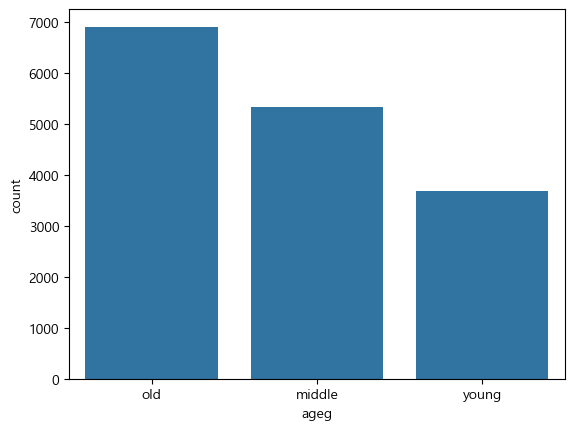

In [12]:
# 빈도 그래프
sns.countplot(data=welfare, x= 'ageg')

### 연령대 별 취업률과 실업률 비율 

In [14]:
welfare['eW'].describe()

count    14422.000000
mean         5.621620
std          3.330262
min          1.000000
25%          2.000000
50%          6.000000
75%          9.000000
max          9.000000
Name: eW, dtype: float64

In [15]:
welfare['eW'].dtype
welfare['eW'].value_counts() # 빈도수 

eW
9.0    6042
1.0    2757
2.0    1880
6.0    1627
4.0     746
7.0     544
3.0     477
5.0     199
8.0     150
Name: count, dtype: int64

In [16]:
#이상치 결측 처리 

welfare['eW']=np.where(welfare['eW'] == 99, np.nan, welfare['eW'])


# 결측 확인
print("결측 확인:", welfare['eW'].isna().sum()) 
welfare['eW'].isna().sum()

결측 확인: 1509


np.int64(1509)

In [17]:
welfare=welfare.dropna(subset=['eW'])

In [18]:
welfare = welfare.assign(ewg = np.where(welfare['eW'] <= 7, '취업률',
                               np.where(welfare['eW'] == 8, '실업률','비경제')))
welfare['ewg'].value_counts()

ewg
취업률    8230
비경제    6042
실업률     150
Name: count, dtype: int64

In [19]:
n_Employment =welfare.groupby('ewg',as_index=False)\
                 .agg(n= ('ewg','count'))
n_Employment

,ewg,n
0,비경제,6042
1,실업률,150
2,취업률,8230


<Axes: xlabel='ewg', ylabel='n'>

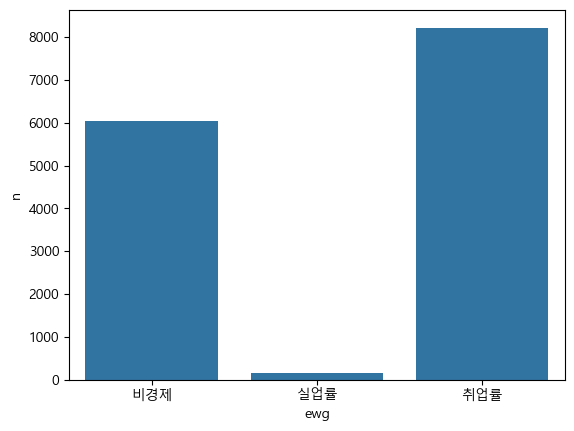

In [20]:
sns.barplot(data = n_Employment, x='ewg', y='n')


In [21]:
age_eW = welfare.groupby('ageg',as_index=False)\
                 ['ewg']\
                 .value_counts(normalize=True)
age_eW

,ageg,ewg,proportion
0,middle,취업률,0.785728
1,middle,비경제,0.199663
2,middle,실업률,0.014609
3,old,비경제,0.555395
4,old,취업률,0.440989
5,old,실업률,0.003616
6,young,비경제,0.523744
7,young,취업률,0.454587
8,young,실업률,0.021669


<Axes: xlabel='proportion', ylabel='ewg'>

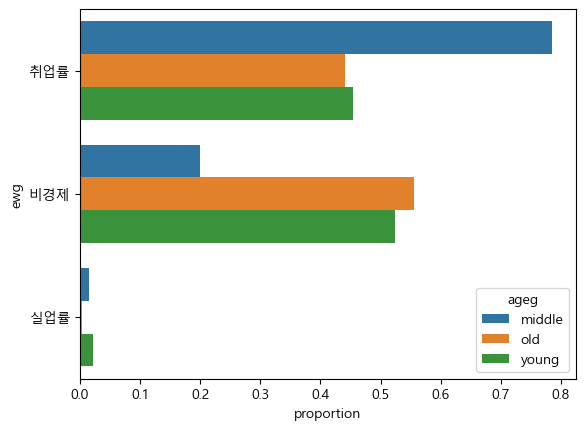

In [22]:
sns.barplot(data=age_eW, y='ewg', x='proportion',hue='ageg')


In [23]:
pivot_df=\
    age_eW[['ewg','ageg','proportion']].pivot(index='ewg',
                                              columns='ageg',
                                              values='proportion')
pivot_df

ageg,middle,old,young
ewg,,,
비경제,0.199663,0.555395,0.523744
실업률,0.014609,0.003616,0.021669
취업률,0.785728,0.440989,0.454587


<Axes: ylabel='ewg'>

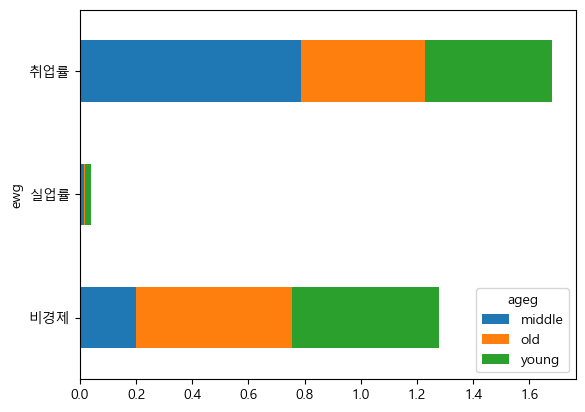

In [24]:
pivot_df.plot.barh(stacked=True)

In [25]:
welfare['no_eW'].dtype
welfare['no_eW'].value_counts() # 빈도수 

no_eW
10.0    3649
3.0      788
6.0      755
9.0      234
5.0      185
1.0      154
7.0      144
4.0       51
8.0       39
2.0       28
11.0      15
Name: count, dtype: int64

In [26]:
#이상치 결측 처리 

welfare['no_eW']=np.where(welfare['no_eW'] == 99, np.nan, welfare['no_eW'])


# 결측 확인
print("결측 확인:", welfare['no_eW'].isna().sum()) 
welfare['no_eW'].isna().sum()

결측 확인: 8380


np.int64(8380)